In [6]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [7]:
data = pd.read_csv("../../data/clean/mbti_4.csv")
train, test = train_test_split(data, test_size = 0.1, random_state=88, stratify=data.type)
features = ['com_stmt', 'pos_stmt', 'neg_stmt', 'neu_stmt', 'word_count',
            'unique_count', 'emoji_count', 'qe_mark', 'ex_mark', 'el_mark',
            'upper_count', 'url_count', 'img_count']
X_train, y_train = train[features], train['is_F']
X_test, y_test = test[features], test['is_F']
X_train_2, X_test_2 = train.iloc[:, 7:], test.iloc[:, 7:]
y_train_2, y_test_2 = train['type'], test['type']
cv = KFold(n_splits=5,random_state=88,shuffle=True)

In [8]:
#LDA Classifier with all 16 types
lda = LinearDiscriminantAnalysis().fit(X_train_2, y_train_2)
model_lda_acc = lda.score(X_test_2, y_test_2)# Calculate LDA accuracy
print(f'LDA Test Accuracy: {model_lda_acc:.4f}')

LDA Test Accuracy: 0.3016


In [9]:
# decision tree
tree_param = [{'criterion': ['entropy', 'gini'], 'max_depth': np.arange(2, 10)}]
clff = DecisionTreeClassifier(max_depth=3, criterion = 'gini', random_state = 88)
dtree_gscv2 = GridSearchCV(clff, tree_param, cv=5)
dtree_gscv2.fit(X_train_2, y_train_2)
best_dtree_pred2 = dtree_gscv2.best_estimator_.predict(X_test_2)

print("accuracy score of decison tree:", accuracy_score(y_test_2, best_dtree_pred2))

accuracy score of decison tree: 0.4126984126984127


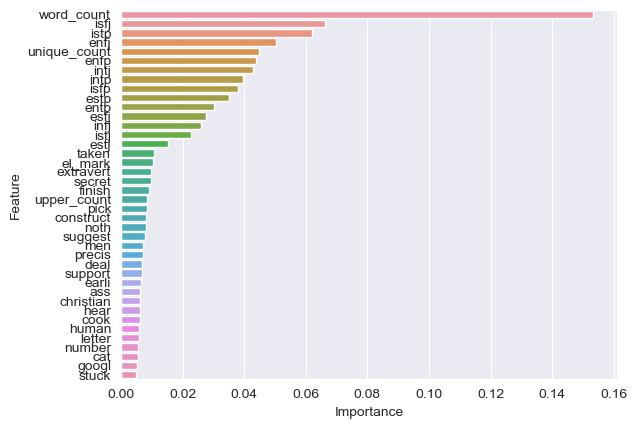

In [10]:
# filter features based on feature importance
feat_importances = pd.concat([pd.DataFrame(X_train_2.columns),pd.DataFrame(np.transpose(dtree_gscv2.best_estimator_.feature_importances_))], axis = 1)
feat_importances.columns = ["Feature", "Importance"]
sns.barplot(x = "Importance", y = "Feature", data = feat_importances.nlargest(40, 'Importance'))
plt.show()

In [11]:
feat_importances.sort_values('Importance', ascending=False).head(20)

,Feature,Importance
4,word_count,0.153312
769,isfj,0.066216
774,istp,0.062142
459,enfj,0.050347
5,unique_count,0.044749
460,enfp,0.043772
754,intj,0.042793
755,intp,0.039582
770,isfp,0.037983
481,estp,0.034973


In [12]:
# SVC for 16 types
#Support Vector Classifier (simple version -- no grid search / no cv)
from sklearn.svm import SVC
svc2 = SVC(C=0.1).fit(X_train_2, y_train_2)
y_pred_svc2 = svc2.predict(X_test_2)
model_svc_acc2 = sum(y_pred_svc2 == y_test_2) / len(y_test_2)
print(f'SVC Test Accuracy: {model_svc_acc2:.4f}')

SVC Test Accuracy: 0.0476


In [ ]:
# #Adaboost for 16 types
# #Adaboost Classifier (simple version, grid-search cv not runnable)
# from sklearn.ensemble import AdaBoostClassifier
# abc2 = AdaBoostClassifier(random_state=88).fit(X_train_2, y_train_2)
# abc_grid = {'base_estimator' : ['gini', 'entropy'],
#            'algorithm' : ['SAMME', 'SAMME.R'],
#            'n_estimators' : [1],
#            'learning_rate' : np.linspace(0.1, 1, 10)
#            }
# abc_search = GridSearchCV(abc, param_grid=abc_grid, cv=cv, scoring='accuracy', n_jobs=-1).fit(X_train_2, y_train)
# y_pred_abc2 = abc2.predict(X_test_2)
# model_abc_acc2 = sum(y_pred_abc2 == y_test_2) / len(y_test_2)
# print(f'ABC Test Accuracy: {model_abc_acc2:.4f}')
# #print(abc_search.best_score_)
# #abc_best = abc_search.best_estimator_

In [17]:
##Gradient Boosting for 16 types
#Gradient Boosting Classifier (got high acc, skip grid-search)
gbc2 = GradientBoostingClassifier(n_estimators=3300, max_leaf_nodes=10,
                                 random_state=88).fit(X_train_2, y_train_2)
y_pred_gbc2 = gbc2.predict(X_test_2)
model_gbc_acc2 = sum(y_pred_gbc2 == y_test_2) / len(y_test_2)# Calculate boosting accuracy
print(f'GBC Test Accuracy: {model_gbc_acc2:.4f}')

GBC Test Accuracy: 0.4603


In [18]:
#Grid-Search 5Fold-Cross-validation Random Forest to find best max_feature
grid_values = {'max_features': np.linspace(1,100,100, dtype='int32'),
               'random_state': [88]}
rf2 = RandomForestClassifier(random_state=88)
rf2_cv = GridSearchCV(rf2, param_grid=grid_values, scoring='accuracy', cv=cv, verbose=1)
rf2_cv.fit(X_train_2, y_train_2)
y_pred_rf2 = rf2_cv.best_estimator_.predict(X_test_2)
model_rf2_acc = sum(y_pred_rf2 == y_test_2) / len(y_test_2)
print(f'CV Random Forest Test Accuracy: {model_rf2_acc:.4f}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CV Random Forest Test Accuracy: 0.5873


In [19]:
#Grid-Search 5-Cross-Validation Support Vector Classifier
svc = SVC(random_state=88, probability=True)
svc_grid = {"kernel": ["rbf"],
             "gamma": [0.5]
             }
svc_search = GridSearchCV(svc, param_grid=svc_grid, cv=cv, scoring='accuracy', n_jobs=-1).fit(X_train_2, y_train_2)
y_pred_svc = svc_search.best_estimator_.predict(X_test_2)
model_svc_acc = sum(y_pred_svc == y_test_2) / len(y_test_2)
# svc_best = svc_search.best_estimator_
print(f'SVC Accuracy: {model_svc_acc:.4f}')

SVC Accuracy: 0.0476


In [20]:
##Grid-Search 5-Cross-Validation Stochastic Gradient Descent Classifier
from sklearn.linear_model import SGDClassifier
sgdc = SGDClassifier(random_state=88)
sgdc_grid = {"loss": ["hinge"],
             "penalty": ["l1", "l2"],
             "alpha": np.linspace(0.0001,0.0005,5)}
sgdc_search = GridSearchCV(sgdc, param_grid=sgdc_grid, cv=cv, scoring='accuracy', n_jobs=-1).fit(X_train_2, y_train_2)
sgdc_best = sgdc_search.best_estimator_
y_pred_sgdc = sgdc_best.predict(X_test_2)
model_sgdc_acc = sum(y_pred_sgdc == y_test_2) / len(y_test_2)
print(sgdc_search.best_score_)
print(f'Sgdc Accuracy: {model_sgdc_acc:.4f}')

0.5185840707964602
Sgdc Accuracy: 0.4444


In [ ]:
#models_result = pd.DataFrame({
#'Model':['Logistic Regression', 'Simple Random Forest', 'Random Forest', 'Simple Gradient Boosting', 'Simple AdaBoost', 'Stochastic Gradient Descent', 'Simple Support Vector Classifier', 'K-Nearest Neighbors', 'LDA-16types'],
#'Accuracy':[model_logreg_acc,  model_rf_acc, model_rf2_acc, model_gbc_acc, model_abc_acc, sgdc_search.best_score_, model_svc_acc, svc_search.best_score_, knn_search.best_score_, model_lda_acc]})